In [1]:
import pandas as pd
import csv
from pathlib import Path
import json
import time
from tqdm import tqdm
import numpy as np
import gc
import os
import pickle
import ast

## memory
import psutil


def get_mem():
    mem = psutil.virtual_memory()
    total = str(round(mem.total / 1024 / 1024))
    #round方法进行四舍五入，然后转换成字符串 字节/1024得到kb 再/1024得到M
    used = str(round(mem.used / 1024 / 1024))
    use_per = str(round(mem.percent))
    free = str(round(mem.free / 1024 / 1024))
    print("已使用:" + used + "M(" + use_per + "%)")
    print("可用内存:" + free + "M")

data_dir = Path('./data/public')
train_group = data_dir/"train.group.csv"
train_json = data_dir/"train.func.json"
test_json = data_dir/"test.func.json"
test_q = data_dir/"test.question.csv"

In [2]:
# int -> int
inv_dict = dict()
g_cnt = 0
id_cnt = 0
mx_cnt = 0
mn_cnt = 1e9

mx_group_id = 0
with open(train_group) as f:
    reader = csv.reader(f)
    for row in reader:
        group_id = row[0]
        g_cnt += 1
        mx_cnt = max(len(row[1:]), mx_cnt)
        mn_cnt = min(len(row[1:]), mn_cnt)
        mx_group_id = max(int(group_id), mx_group_id)
        for func_id in row[1:]:
            id_cnt += 1
            inv_dict[int(func_id)] = int(group_id)
            
        
avg_cnt = id_cnt * 1. / g_cnt
print(len(inv_dict.keys()), g_cnt, mx_cnt, mn_cnt, avg_cnt)
mx_group_id

2270931 70000 60 5 32.44187142857143


70000

In [3]:
# data = json.load(open(train_json, "r"))
# df = pd.DataFrame.from_dict(data, orient="index")
# gc.collect()
# itvs = np.linspace(1, 70001, 20)

# for i in range(len(itvs)-1):
#     lb, rb = itvs[i], itvs[i+1]
#     # print(lb, rb)
#     itv_dict = {k:v for k, v in inv_dict.items() if lb<=v and v<rb}
#     dfs = pd.read_json(train_json, orient="records", lines=True, chunksize=6e4)
    
#     res = []
#     for idx, df in enumerate(tqdm(dfs)):
#         df = df[df.fid.isin(itv_dict.keys())]
#         df['gid'] = df.fid.apply(lambda x: itv_dict[x])
#         res.append(df)
#         gc.collect()
#     res = pd.concat(res)
#     get_mem()
#     for row, gdf in res.groupby("gid"):
#         gdf.to_json(data_dir/f"train/{gdf.gid.max()}.json",  orient="records") # to_json does not have append mode
        

# data = json.load(open(train_json, "r"))
# df = pd.DataFrame.from_dict(data, orient="index")
gc.collect()
dfs = pd.read_json(train_json, orient="records", lines=True, chunksize=4e4)

res = []
for idx, df in enumerate(tqdm(dfs)):
    # df = df[df.fid.isin(itv_dict.keys())]
    df['gid'] = df.fid.apply(lambda x: inv_dict[x])
    gc.collect()
    for row, gdf in df.groupby("gid"):
        output_path = data_dir/f"train/{gdf.gid.max()}.csv"
        gdf.to_csv(output_path,  mode='a', header=not os.path.exists(output_path))

    get_mem()
    

0it [00:09, ?it/s]


KeyboardInterrupt: 

In [13]:
test_df = pd.read_json(test_json, orient="records", lines=True)


KeyboardInterrupt



In [ ]:
len(test_df)

In [6]:
# int -> int
inv_dict = dict()
g_cnt = 0
id_cnt = 0
mx_cnt = 0
mn_cnt = 1e9

mx_group_id = 0
with open(test_q) as f:
    reader = csv.reader(f)
    for row in reader:
        group_id = row[0]
        g_cnt += 1
        mx_cnt = max(len(row[1:]), mx_cnt)
        mn_cnt = min(len(row[1:]), mn_cnt)
        mx_group_id = max(int(group_id), mx_group_id)
        for func_id in row[1:]:
            id_cnt += 1
            inv_dict[int(func_id)] = int(group_id)
            
        
avg_cnt = id_cnt * 1. / g_cnt
print(len(inv_dict.keys()), g_cnt, mx_cnt, mn_cnt, q)
mx_group_id

NameError: name 'q' is not defined

## sample

In [7]:
total = 7e4
block = 100
itvs = np.linspace(1, total+1, block+1)

arr = np.arange(total)
arr = arr+1
np.random.shuffle(arr)

In [8]:
# block = 100
from numpy.random import default_rng
# for random sample without duplicates
rng = default_rng()


def sample_neg(cur_list, anchor_list, n_sample=10):
    res = []
    for pid in cur_list:
        #print(len(anchor_list), rng.choice(len(anchor_list), n_sample*2))
        t = anchor_list[rng.choice(len(anchor_list), n_sample*3)]
        t = list(set(t) - set(cur_list))[:n_sample]
        res += [(pid, i, 0) for i in t]
        # print("neg:", pid, cur_list, t)
    # print("neg:", len(cur_list), len(res))
    return res

def sample_pos(cur_list, n_sample=1):
    res = []
    for pid in cur_list:
        t = []
        while len(t) < n_sample:
            t_id = cur_list[np.random.choice(len(cur_list), 1)[0]]
            # print(len(cur_list), np.random.choice(len(cur_list), 1)[0])
            if t_id not in t and t_id != pid:
                t.append(t_id)
        res += [(pid, i, 1) for i in t]
    # print("pos:", cur_list, res)
    return res

for i in tqdm(range(block)):
    lb, rb = int(itvs[i]), int(itvs[i+1])
    paths_block = [data_dir/f"train/{int(gid)}.csv" for gid in arr[lb:rb]]
    #print(paths_block[:5])
    df = pd.concat([pd.read_csv(path) for path in paths_block])
    
    id_list = df["fid"].values
    pair_list = []
    for idx, gdf in df.groupby("gid"):
        cur_list = gdf["fid"].values
        pair_list += sample_neg(cur_list, id_list)
        pair_list += sample_pos(cur_list)
    print(len(pair_list), len(df))
    df.to_csv(data_dir/f"train/block{i}.csv")
    pickle.dump(pair_list, open(data_dir/f"train/block{i}.bin", "wb"))
        

  0%|                                                                                                                                                                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

249568 22688


  1%|███▋                                                                                                                                                                                                                                                                                                                                                                                 | 1/100 [01:57<3:13:31, 117.28s/it]

254914 23174


  2%|███████▍                                                                                                                                                                                                                                                                                                                                                                             | 2/100 [03:58<3:15:24, 119.63s/it]

251163 22833


  3%|███████████▏                                                                                                                                                                                                                                                                                                                                                                         | 3/100 [06:02<3:16:27, 121.52s/it]

252483 22953


  4%|██████████████▉                                                                                                                                                                                                                                                                                                                                                                      | 4/100 [08:07<3:16:47, 122.99s/it]

249183 22653


  5%|██████████████████▋                                                                                                                                                                                                                                                                                                                                                                  | 5/100 [10:09<3:13:55, 122.48s/it]

247467 22497


  6%|██████████████████████▍                                                                                                                                                                                                                                                                                                                                                              | 6/100 [12:08<3:09:58, 121.26s/it]

250349 22759


  7%|██████████████████████████                                                                                                                                                                                                                                                                                                                                                           | 7/100 [14:06<3:06:19, 120.21s/it]

256355 23305


  8%|█████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                       | 8/100 [16:13<3:07:37, 122.37s/it]

256476 23316


  9%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                   | 9/100 [18:17<3:06:42, 123.10s/it]

246268 22388


 10%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                              | 10/100 [20:29<3:08:42, 125.81s/it]

250602 22782


 11%|████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                           | 11/100 [22:37<3:07:41, 126.53s/it]

251218 22838


 12%|████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                       | 12/100 [24:41<3:04:10, 125.58s/it]

249887 22717


 13%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                   | 13/100 [26:48<3:02:45, 126.04s/it]

246378 22398


 14%|████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                | 14/100 [28:50<2:58:59, 124.88s/it]

252373 22943


 15%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                            | 15/100 [30:57<2:57:39, 125.41s/it]

252230 22930


 16%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                        | 16/100 [32:59<2:54:26, 124.60s/it]

254001 23091


 17%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                    | 17/100 [35:06<2:53:05, 125.13s/it]

254397 23127


 18%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                 | 18/100 [37:01<2:46:45, 122.02s/it]

249546 22686


 19%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                             | 19/100 [39:00<2:43:36, 121.19s/it]

249271 22661


 20%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                         | 20/100 [41:03<2:42:17, 121.72s/it]

251691 22881


 21%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                      | 21/100 [43:09<2:42:08, 123.15s/it]

247478 22498


 22%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 22/100 [45:12<2:40:07, 123.17s/it]

255497 23227


 23%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                              | 23/100 [47:22<2:40:24, 124.99s/it]

253000 23000


 24%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                          | 24/100 [49:24<2:37:22, 124.24s/it]

256707 23337


 25%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 25/100 [51:31<2:36:08, 124.91s/it]

244200 22200


 26%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                   | 26/100 [53:31<2:32:20, 123.52s/it]

248116 22556


 27%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                               | 27/100 [55:41<2:32:46, 125.57s/it]

244211 22201


 28%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                           | 28/100 [57:47<2:30:49, 125.69s/it]

248589 22599


 29%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 29/100 [59:52<2:28:22, 125.38s/it]

260073 23643


 30%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                   | 30/100 [1:01:55<2:25:18, 124.55s/it]

248072 22552


 31%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                               | 31/100 [1:04:01<2:24:00, 125.22s/it]

256058 23278


 32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                           | 32/100 [1:06:05<2:21:21, 124.73s/it]

245542 22322


 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                        | 33/100 [1:08:15<2:21:11, 126.43s/it]

249931 22721


 34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 34/100 [1:10:15<2:16:59, 124.54s/it]

257158 23378


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                | 35/100 [1:12:17<2:13:57, 123.66s/it]

244090 22190


 36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                            | 36/100 [1:14:23<2:12:42, 124.42s/it]

250173 22743


 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                         | 37/100 [1:16:32<2:12:03, 125.77s/it]

254188 23108


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                     | 38/100 [1:18:41<2:10:54, 126.69s/it]

255255 23205


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 39/100 [1:20:42<2:07:13, 125.14s/it]

260524 23684


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                              | 40/100 [1:22:51<2:06:09, 126.16s/it]

252032 22912


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                          | 41/100 [1:25:00<2:04:53, 127.01s/it]

254496 23136


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                      | 42/100 [1:27:05<2:02:08, 126.35s/it]

252450 22950


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                   | 43/100 [1:29:10<1:59:35, 125.89s/it]

252989 22999


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 44/100 [1:31:38<2:03:42, 132.55s/it]

251449 22859


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                           | 45/100 [1:33:47<2:00:38, 131.62s/it]

255024 23184


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                       | 46/100 [1:35:55<1:57:25, 130.47s/it]

260337 23667


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 47/100 [1:37:55<1:52:21, 127.20s/it]

252109 22919


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 48/100 [1:40:01<1:49:57, 126.88s/it]

253407 23037


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 49/100 [1:41:59<1:45:40, 124.32s/it]

250316 22756


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                         | 50/100 [1:43:59<1:42:25, 122.92s/it]

253572 23052


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 51/100 [1:46:01<1:40:17, 122.81s/it]

241373 21943


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 52/100 [1:48:01<1:37:28, 121.85s/it]

243914 22174


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 53/100 [1:49:54<1:33:23, 119.22s/it]

245685 22335


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 54/100 [1:51:57<1:32:19, 120.43s/it]

264616 24056


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 55/100 [1:54:00<1:30:45, 121.01s/it]

251724 22884


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 56/100 [1:56:13<1:31:24, 124.64s/it]

244970 22270


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 57/100 [1:58:15<1:28:52, 124.00s/it]

249216 22656


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 58/100 [2:00:14<1:25:48, 122.59s/it]

255893 23263


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 59/100 [2:02:21<1:24:29, 123.66s/it]

255904 23264


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 60/100 [2:04:21<1:21:52, 122.81s/it]

250481 22771


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 61/100 [2:06:24<1:19:51, 122.86s/it]

256707 23337


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 62/100 [2:08:28<1:17:54, 123.00s/it]

251911 22901


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 63/100 [2:10:30<1:15:45, 122.85s/it]

249491 22681


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 64/100 [2:12:34<1:13:50, 123.08s/it]

254199 23109


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 65/100 [2:14:37<1:11:44, 122.99s/it]

250096 22736


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 66/100 [2:16:40<1:09:47, 123.17s/it]

249150 22650


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 67/100 [2:19:03<1:10:59, 129.08s/it]

261404 23764


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 68/100 [2:21:09<1:08:16, 128.01s/it]

245014 22274


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 69/100 [2:23:15<1:05:54, 127.57s/it]

259853 23623


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 70/100 [2:25:19<1:03:11, 126.37s/it]

250316 22756


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 71/100 [2:27:21<1:00:32, 125.27s/it]

258434 23494


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 72/100 [2:29:22<57:44, 123.75s/it]

251460 22860


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 73/100 [2:31:22<55:12, 122.69s/it]

254947 23177


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 74/100 [2:33:21<52:44, 121.73s/it]

251669 22879


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 75/100 [2:35:29<51:24, 123.38s/it]

249084 22644


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 76/100 [2:37:31<49:16, 123.18s/it]

246444 22404


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/100 [2:39:34<47:10, 123.06s/it]

255970 23270


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 78/100 [2:41:48<46:16, 126.20s/it]

251647 22877


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 79/100 [2:43:47<43:25, 124.09s/it]

251053 22823


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 80/100 [2:45:43<40:37, 121.85s/it]

255541 23231


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 81/100 [2:47:54<39:27, 124.59s/it]

249348 22668


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 82/100 [2:50:10<38:21, 127.87s/it]

256487 23317


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 83/100 [2:52:27<37:02, 130.75s/it]

253726 23066


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 84/100 [2:54:28<34:03, 127.74s/it]

261030 23730


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 85/100 [2:56:38<32:06, 128.43s/it]

242451 22041


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 86/100 [2:58:37<29:18, 125.60s/it]

258401 23491


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 87/100 [3:00:40<27:04, 124.94s/it]

250602 22782


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 88/100 [3:02:51<25:20, 126.70s/it]

253561 23051


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 89/100 [3:05:15<24:08, 131.71s/it]

246642 22422


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 90/100 [3:07:19<21:34, 129.50s/it]

253110 23010


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 91/100 [3:09:16<18:52, 125.78s/it]

259677 23607


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 92/100 [3:11:26<16:56, 127.01s/it]

255706 23246


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 93/100 [3:13:40<15:02, 128.99s/it]

248369 22579


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 94/100 [3:15:45<12:48, 128.02s/it]

251471 22861


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 95/100 [3:17:49<10:34, 126.83s/it]

249370 22670


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 96/100 [3:19:46<08:14, 123.66s/it]

256894 23354


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 97/100 [3:21:46<06:07, 122.58s/it]

259688 23608


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 98/100 [3:23:50<04:06, 123.23s/it]

252384 22944


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 99/100 [3:25:53<02:03, 123.06s/it]

246994 22454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [3:28:09<00:00, 124.90s/it]


In [50]:
df = pd.read_csv(data_dir/f"train/block{int(1)}.csv")


In [51]:
pd.set_option('max_colwidth', 500)
df["code"].head()

0    [[4789496, 'fd7bb8a9', 'stp\tx29, x30, [sp, #-0x80]!'], [4789500, 'fd030091', 'mov\tx29, sp'], [4789504, 'f35301a9', 'stp\tx19, x20, [sp, #0x10]'], [4789508, 'fb7305a9', 'stp\tx27, x28, [sp, #0x50]'], [4789512, 'fb0300aa', 'mov\tx27, x0'], [4789516, 'e13f00f9', 'str\tx1, [sp, #0x78]'], [4789520, '009864b9', 'ldr\tw0, [x0, #0x2498]'], [4789524, '1f000071', 'cmp\tw0, #0'], [4789528, '8d0e0054', 'b.le\t#0x4916e8'], [4789532, 'f55b02a9', 'stp\tx21, x22, [sp, #0x20]'], [4789536, 'f76303a9', 'stp\...
1    [[4035574, '4157', 'push\tr15'], [4035576, '4531c0', 'xor\tr8d, r8d'], [4035579, '4531ff', 'xor\tr15d, r15d'], [4035582, '4156', 'push\tr14'], [4035584, '4155', 'push\tr13'], [4035586, '4989f5', 'mov\tr13, rsi'], [4035589, '4154', 'push\tr12'], [4035591, '55', 'push\trbp'], [4035592, '4889fd', 'mov\trbp, rdi'], [4035595, '53', 'push\trbx'], [4035596, '31db', 'xor\tebx, ebx'], [4035598, '4883ec28', 'sub\trsp, 0x28'], [4035602, '4439bd98240000', 'cmp\tdword ptr [rbp + 0x2498], r15d'], [4

In [52]:
df.head()

,Unnamed: 0.1,Unnamed: 0,fid,arch,compiler,opti,code,block,cfg,gid
0,0,143020,69478,arm_64,gcc,O1,"[[4789496, 'fd7bb8a9', 'stp\tx29, x30, [sp, #-0x80]!'], [4789500, 'fd030091', 'mov\tx29, sp'], [4789504, 'f35301a9', 'stp\tx19, x20, [sp, #0x10]'], [4789508, 'fb7305a9', 'stp\tx27, x28, [sp, #0x50]'], [4789512, 'fb0300aa', 'mov\tx27, x0'], [4789516, 'e13f00f9', 'str\tx1, [sp, #0x78]'], [4789520, '009864b9', 'ldr\tw0, [x0, #0x2498]'], [4789524, '1f000071', 'cmp\tw0, #0'], [4789528, '8d0e0054', 'b.le\t#0x4916e8'], [4789532, 'f55b02a9', 'stp\tx21, x22, [sp, #0x20]'], [4789536, 'f76303a9', 'stp\...","[[0, 4789496, 4789532], [1, 4789532, 4789572], [2, 4789572, 4789588], [3, 4789588, 4789612], [4, 4789612, 4789628], [5, 4789628, 4789636], [6, 4789636, 4789640], [7, 4789640, 4789652], [8, 4789652, 4789684], [9, 4789684, 4789700], [10, 4789700, 4789708], [11, 4789708, 4789712], [12, 4789712, 4789752], [13, 4789752, 4789796], [14, 4789796, 4789808], [15, 4789808, 4789820], [16, 4789820, 4789844], [17, 4789844, 4789860], [18, 4789860, 4789892], [19, 4789892, 4789932], [20, 4789932, 4789948], [...","[[0, 1], [0, 22], [1, 13], [2, 3], [3, 4], [3, 3], [4, 5], [4, 30], [5, 2], [5, 6], [6, 4], [7, 8], [8, 9], [8, 8], [9, 10], [9, 26], [10, 7], [10, 11], [11, 9], [12, 13], [12, 14], [13, 28], [14, 15], [14, 21], [15, 16], [16, 17], [16, 23], [17, 18], [18, 19], [18, 24], [19, 20], [22, 16], [23, 18], [24, 20], [25, 26], [25, 32], [26, 12], [26, 27], [27, 28], [28, 25], [28, 29], [29, 5], [30, 31], [30, 33], [31, 10], [32, 27], [33, 31]]",50694
1,1,168406,2050011,x86_64,gcc,Os,"[[4035574, '4157', 'push\tr15'], [4035576, '4531c0', 'xor\tr8d, r8d'], [4035579, '4531ff', 'xor\tr15d, r15d'], [4035582, '4156', 'push\tr14'], [4035584, '4155', 'push\tr13'], [4035586, '4989f5', 'mov\tr13, rsi'], [4035589, '4154', 'push\tr12'], [4035591, '55', 'push\trbp'], [4035592, '4889fd', 'mov\trbp, rdi'], [4035595, '53', 'push\trbx'], [4035596, '31db', 'xor\tebx, ebx'], [4035598, '4883ec28', 'sub\trsp, 0x28'], [4035602, '4439bd98240000', 'cmp\tdword ptr [rbp + 0x2498], r15d'], [4035609...","[[0, 4035574, 4035602], [1, 4035602, 4035615], [2, 4035615, 4035638], [3, 4035638, 4035752], [4, 4035752, 4035759], [5, 4035759, 4035778], [6, 4035778, 4035783], [7, 4035783, 4035809], [8, 4035809, 4035817], [9, 4035817, 4035822], [10, 4035822, 4035878], [11, 4035878, 4035884], [12, 4035884, 4035891], [13, 4035891, 4035902], [14, 4035902, 4035907], [15, 4035907, 4035941], [16, 4035941, 4035949], [17, 4035949, 4035969], [18, 4035969, 4035984], [19, 4035984, 4035992], [20, 4035992, 4036035], [...","[[0, 1], [1, 2], [1, 19], [2, 3], [3, 4], [4, 5], [4, 9], [5, 6], [6, 7], [6, 8], [7, 6], [8, 4], [9, 10], [9, 11], [10, 11], [11, 12], [12, 13], [12, 17], [13, 14], [14, 15], [14, 16], [15, 14], [16, 12], [17, 3], [17, 18], [18, 1], [19, 20], [19, 21], [21, 22], [21, 23], [22, 24], [23, 24], [24, 25], [24, 26], [25, 26]]",50694
2,2,495454,3008163,arm_32,gcc,O0,"[[10951148, '30482de9', 'push\t{r4, r5, fp, lr}'], [10951152, '0cb08de2', 'add\tfp, sp, #0xc'], [10951156, '58d04de2', 'sub\tsp, sp, #0x58'], [10951160, '58000be5', 'str\tr0, [fp, #-0x58]'], [10951164, '5c100be5', 'str\tr1, [fp, #-0x5c]'], [10951168, 'dc449fe5', 'ldr\tr4, [pc, #0x4dc]'], [10951172, '0000a0e1', 'mov\tr0, r0'], [10951176, '0030a0e3', 'mov\tr3, #0'], [10951180, '50300be5', 'str\tr3, [fp, #-0x50]'], [10951184, '0030a0e3', 'mov\tr3, #0'], [10951188, '4c300be5', 'str\tr3, [fp, #-0...","[[0, 10951148, 10951196], [1, 10951196, 10951224], [2, 10951224, 10951404], [3, 10951404, 10951412], [4, 10951412, 10951428], [5, 10951428, 10951436], [6, 10951436, 10951440], [7, 10951440, 10951516], [8, 10951516, 10951528], [9, 10951528, 10951624], [10, 10951624, 10951640], [11, 10951640, 10951652], [12, 10951652, 10951668], [13, 10951668, 10951680], [14, 10951680, 10951716], [15, 10951716, 10951728], [16, 10951728, 10951740], [17, 10951740, 10951836], [18, 10951836, 10951852], [19, 109518...","[[0, 24], [1, 22], [2, 3], [2, 4], [3, 7],

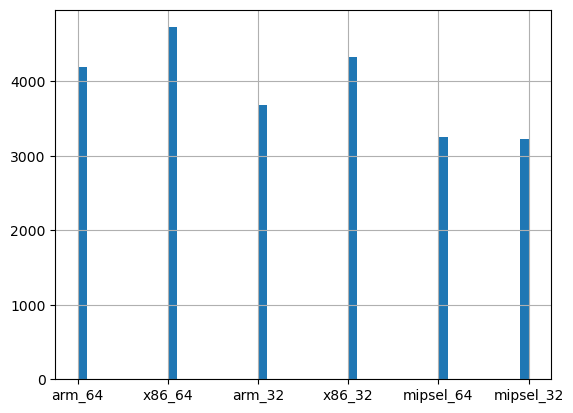

In [53]:
df.arch.hist(bins=50)

<AxesSubplot:>

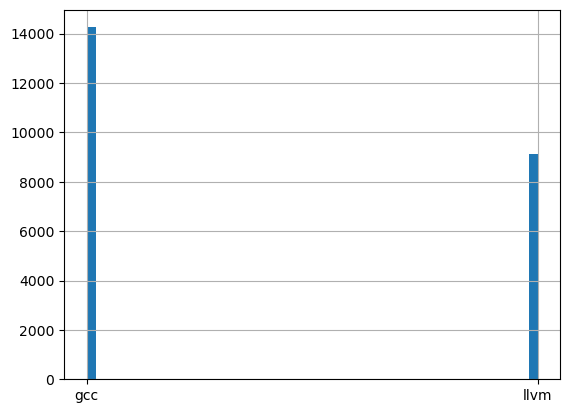

In [54]:
df.compiler.hist(bins=50)

<AxesSubplot:>

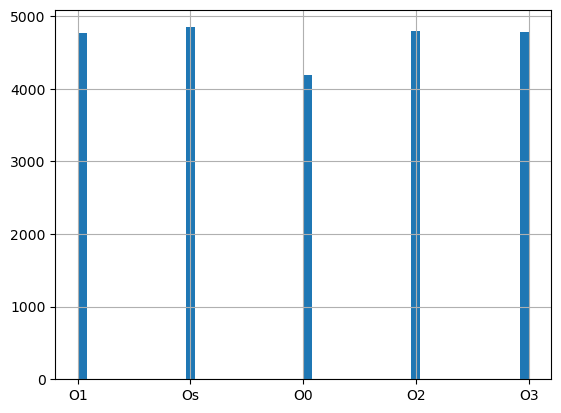

In [55]:
df.opti.hist(bins=50)

## sent1 sent2 neg format

In [3]:
!ls

 cd_train.py			       preprocess_mucgec.py
 data				       preprocess.py
 dataset.py			       PW.ipynb
'EDA for linux code detection.ipynb'   __pycache__
 infer.sh			       run.sh
 lm_train.py			       submission.csv
 log				       submission_ensemble.csv
 LSTM.ipynb			       test.py
 metrics.py			       train.log
 microsoft			       train.py
 model.py			       Untitled.ipynb
 outputs			       utils
 pooling.py			       yb_train.py


In [2]:
from utils.preprocess import get_code_dict, get_group_dict

In [16]:
# del df
triple = []
for i in tqdm(range(100)):
    #if e == 0 and i <= 42:
    #    continue
    print("block:", i)
    train_pairs = pickle.load(open(f"./data/public/train/block{i}.bin", "rb"))
    train_df = pd.read_csv(f"./data/public/train/block{i}.csv")
    code_dict = get_code_dict(train_df)
    # group_dict = get_group_dict(train_df)
    
    t = {}
    s = {}
    
    print("finish loading.")
    for p1, p2, lable in train_pairs:
        c1, c2 = code_dict[p1], code_dict[p2]
        if lable == 1:
            for neg in s[c1]:
                triple.append([c1, c2, neg])
        else:
            if c1 not in s:
                s[c1] = [c2]
            else:
                s[c1].append(c2)
            # triple.append([c1, t[c1], c2])

    del train_pairs, train_df, code_dict
    get_mem()
    if i>5:
        break
    
    
    print("\n"*2)
df = pd.DataFrame(triple, columns=["sent1", "sent2", "hard_neg"])
df.to_csv("cdmini_for_simcse.csv", index=False)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

block: 0
finish loading.


  1%|███▊                                                                                                                                                                                                                                                                                                                                                                                    | 1/100 [00:12<20:30, 12.43s/it]

已使用:16707M(55%)
可用内存:3835M



block: 1
finish loading.


  2%|███████▌                                                                                                                                                                                                                                                                                                                                                                                | 2/100 [00:29<24:41, 15.12s/it]

已使用:16699M(55%)
可用内存:3688M



block: 2
finish loading.


  3%|███████████▎                                                                                                                                                                                                                                                                                                                                                                            | 3/100 [00:47<26:21, 16.31s/it]

已使用:16689M(55%)
可用内存:3541M



block: 3
finish loading.


  4%|███████████████                                                                                                                                                                                                                                                                                                                                                                         | 4/100 [01:07<28:22, 17.73s/it]

已使用:16685M(55%)
可用内存:3387M



block: 4
finish loading.


  5%|██████████████████▊                                                                                                                                                                                                                                                                                                                                                                     | 5/100 [01:26<28:53, 18.25s/it]

已使用:16677M(55%)
可用内存:3233M



block: 5


  6%|██████████████████████▌                                                                                                                                                                                                                                                                                                                                                                 | 6/100 [01:41<27:04, 17.28s/it]

finish loading.
已使用:16671M(55%)
可用内存:3105M



block: 6


  6%|██████████████████████▌                                                                                                                                                                                                                                                                                                                                                                 | 6/100 [02:00<31:20, 20.01s/it]

finish loading.
已使用:16692M(55%)
可用内存:2925M


In [13]:
1

1

## add tokens

In [19]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/mobius/.cache/huggingface/transformers


In [20]:
import re
s = "adfslafjsdl\t sdfa + afds"
re.split('\t| ', s)

['adfslafjsdl', '', 'sdfa', '+', 'afds']

In [33]:
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import AutoTokenizer, BertTokenizer, AutoModel
import ast

test = True

# text = 'ldr\tw5, [x3, #0x2f74]'
# if test:
#     print("raw text:", text)
#     # add_special_tokens=True is set by default
#     text_enc = tokenizer.encode_plus(text)
#     attn_mask = text_enc['attention_mask']
#     text_enc = text_enc['input_ids']

#     for tok in text_enc:
#         print(tok, tokenizer.decode(tok))
#         print(attn_mask)
        
df = pd.concat(
    [
        pd.read_csv(data_dir/f"train/block{block}.csv")
        for block in range(10)
    ]
).set_index('fid', append=True).swaplevel()

print("finished reading notebook.")

col = df['code'].apply(lambda x: ' '.join([y[2] for y in ast.literal_eval(x)]))


finished reading notebook.


In [34]:
import itertools
#a = [['a','b'], ['c']]
l = [re.split(r"\t| |\*|\(|\)", code) for code in tqdm(col)]
# concat list of lists
l = list(itertools.chain.from_iterable(l))
#for code in tqdm(col):
#    l = l + code.replace("\t", " ").split(" ")
print("finished splitting.")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228566/228566 [00:08<00:00, 25560.59it/s]

finished splitting.


In [35]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))


def pr_N_mostFrequentNumber(arr, K = 2000):
    from collections import defaultdict
    
    temp = defaultdict(int)
    for wrd in l:
        temp[wrd] += 1
 
    # getting max frequency
    t = sorted(temp.items(),key=lambda kv:kv[1],reverse=True)
    return t[:K]

words = pr_N_mostFrequentNumber(l)

# col = col.apply(lambda x: len(tokenizer.tokenize(x)))


print(words)
# col.hist(bins=50)

words = [k for k, v in words]
s = set(words)
for idx, row in df.iterrows():
    x = row['code']
    l = [y[2] for y in ast.literal_eval(x)]
    for t in l:
        s.add(t.split("\t")[0])

[('mov', 6219606), ('', 3854610), ('ptr', 3680859), ('dword', 2451596), ('+', 2243853), ('ldr', 1666900), ('move', 1624398), ('add', 1583318), ('$sp', 1547230), ('-', 1541083), ('$v0,', 1518577), ('eax,', 1514757), ('lw', 1418710), ('r3,', 1310720), ('call', 1290102), ('bl', 1175576), ('ld', 1151306), ('[sp,', 1144074), ('eax', 1098922), ('$a0,', 1091204), ('x0,', 1074287), ('push', 1042523), ('$t9,', 1021386), ('r0,', 951903), ('[ebp', 933135), ('qword', 896770), ('cmp', 879416), ('$gp', 806433), ('addiu', 747125), ('b', 675727), ('lea', 675567), ('[rbp', 667661), ('$t9', 662164), ('$at,', 648263), ('sub', 633634), ('r2,', 631778), ('nop', 631333), ('[esp', 629995), ('str', 628315), ('w0,', 621531), ('$a1,', 613270), ('jalr', 608579), ('$gp,', 594684), ('$v0', 591880), ('rdi,', 583338), ('$s0', 576751), ('r1,', 567139), ('esp,', 507443), ('0x10', 493120), ('#0', 486101), ('sw', 482661), ('x1,', 464804), ('edx,', 459143), ('jmp', 458069), ('$zero,', 448362), ('$sp,', 446575), ('daddiu'

In [36]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base") # "microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")       
        
        
# register_words = []
command_words = list(s)
new_words = command_words
print("new_words:", len(new_words))

print(len(tokenizer))
num_added_toks = tokenizer.add_tokens(new_words) #返回一个数，表示加入的新词数量，在这里是2
#关键步骤，resize_token_embeddings输入的参数是tokenizer的新长度
#tokenizer.resize_token_embeddings(len(tokenizer)) 
print(len(tokenizer))



tokenizer.save_pretrained("microsoft/codebert-base-vocabplus")

model.resize_token_embeddings(len(tokenizer)) 
model.save_pretrained("microsoft/codebert-base-vocabplus")
df.head()

new_words: 2703
50265
52857


,,Unnamed: 0.1,Unnamed: 0,arch,compiler,opti,code,block,cfg,gid
fid,,,,,,,,,,
1651875,0,0,53697,mipsel_64,gcc,O1,"[[4831882272, '30ffbd67', 'daddiu\t$sp, $sp, -...","[[0, 4831882272, 4831882396], [1, 4831882396, ...","[[0, 1], [1, 2], [1, 6], [2, 3], [2, 7], [3, 4...",5991
3639551,1,1,155611,arm_64,gcc,O0,"[[43680, 'fd7bb6a9', 'stp\tx29, x30, [sp, #-0x...","[[0, 43680, 43708], [1, 43708, 43920], [2, 439...","[[0, 1], [1, 2], [1, 3], [2, 11], [3, 4], [3, ...",5991
3528955,2,2,158699,arm_64,gcc,Os,"[[41384, 'fd7bb4a9', 'stp\tx29, x30, [sp, #-0x...","[[0, 41384, 41464], [1, 41464, 41572], [2, 415...","[[0, 1], [1, 2], [1, 5], [2, 3], [3, 4], [3, 1...",5991
2161752,3,3,216275,x86_32,gcc,Os,"[[38130, '55', 'push\tebp'], [38131, '89e5', '...","[[0, 38130, 38176], [1, 38176, 38314], [2, 383...","[[0, 1], [1, 2], [1, 3], [2, 9], [3, 4], [3, 6...",5991
2606838,4,4,314769,x86_64,gcc,Os,"[[43466, '55', 'push\trbp'], [43467, '53', 'pu...","[[0, 43466, 43498], [1, 43498, 43681], [2, 436...","[[0, 1], [1, 2], [1, 3], [2, 9], [3, 4], [3, 6...",5991


In [ ]:
col = df['code'].apply(lambda x: ' '.join([y[2] for y in ast.literal_eval(x)]))
cnt_col = df['code'].apply(lambda x: ''.join(["0" for y in ast.literal_eval(x)]))

In [ ]:
col = col.reset_index(drop=True)
col.head(), col.iloc[3], type(col.iloc[3])

In [ ]:
tokenizer.tokenize(col.iloc[20])

In [ ]:
col.iloc[20]

In [ ]:
len_col = col.apply(lambda x: min(len(tokenizer.tokenize(x)), 5000))
cnt_len_col = cnt_col.apply(lambda x: min(len(tokenizer.tokenize(x)), 5000))

In [ ]:
print(max(len_col), len_col.mean(),  min(len_col))
# deberta mean 1353, min 62
# deberta wordplus mean 1285, min 27
# codebert 1252.8829581543469 25
# codebert word1252.8829581543469 25
len_col.hist(bins=50)


In [ ]:
cnt_len_col.hist(bins=50)

In [15]:
tokenizer.save_pretrained("microsoft/codebert-base")

('microsoft/codebert-base/tokenizer_config.json',
 'microsoft/codebert-base/special_tokens_map.json',
 'microsoft/codebert-base/vocab.json',
 'microsoft/codebert-base/merges.txt',
 'microsoft/codebert-base/added_tokens.json',
 'microsoft/codebert-base/tokenizer.json')

In [ ]:
from transformers import BertForMaskedLM, BertTokenizer

model = "Pretrained_LMs/bert-base-cased" 
tokenizer = BertTokenizer.from_pretrained(model, use_fast=True)
model = BertForMaskedLM.from_pretrained(model)

print(tokenizer.tokenize('COVID'))
print(tokenizer.tokenize('hospitalization'))





In [29]:

# col = df['code'].apply(lambda x: '@'.join([y[2] for y in ast.literal_eval(x)]))

666


In [30]:
s

{'adc',
 'adcs',
 'add',
 'add.d',
 'addeq',
 'addge',
 'addgt',
 'addhi',
 'addiu',
 'addle',
 'addlo',
 'addls',
 'addlt',
 'addmi',
 'addne',
 'addp',
 'addpd',
 'adds',
 'addsd',
 'addss',
 'addu',
 'adr',
 'adrp',
 'aesdec',
 'aesdeclast',
 'aesenc',
 'aesenclast',
 'aesimc',
 'and',
 'andeq',
 'andge',
 'andgt',
 'andhi',
 'andi',
 'andle',
 'andls',
 'andlt',
 'andne',
 'andnpd',
 'andnps',
 'andpd',
 'andps',
 'ands',
 'andsne',
 'asr',
 'asreq',
 'asrgt',
 'asrle',
 'asrne',
 'b',
 'b.eq',
 'b.ge',
 'b.gt',
 'b.hi',
 'b.hs',
 'b.le',
 'b.lo',
 'b.ls',
 'b.lt',
 'b.mi',
 'b.ne',
 'b.pl',
 'bal',
 'bc1f',
 'bc1t',
 'beq',
 'beqz',
 'bfi',
 'bfxil',
 'bge',
 'bgez',
 'bgt',
 'bgtz',
 'bhi',
 'bhs',
 'bic',
 'biceq',
 'bicgt',
 'bichs',
 'bicne',
 'bics',
 'bl',
 'ble',
 'blez',
 'blne',
 'blo',
 'blr',
 'bls',
 'blt',
 'bltz',
 'blx',
 'bmi',
 'bne',
 'bnez',
 'bpl',
 'br',
 'brk',
 'bsr',
 'bswap',
 'bt',
 'btc',
 'bx',
 'bxeq',
 'bxle',
 'bxlo',
 'bxls',
 'bxlt',
 'bxne',
 'c.e